## Exploring the impact of double-scoring on PRMSE

In previous notebooks, we have seen that in order to compute PRMSE, we need the responses to have scores from two human raters. However, it may not be practical to have every single repsonses double-scored. In this notebook, we examine how PRMSE depends on the percentage/number of double-scored responses that may be available in the dataset.

To do this, we randomly choose a fixed number of rater pairs in each rater category, then simulate scenarios with a different percentage of double-scored responses for each of those rater pairs, and compute PRMSE for a pre-determined in each scenario.

In [1]:
import itertools
import json
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path
from rsmtool.utils.prmse import prmse_true
from simulation.dataset import Dataset
from simulation.utils import (compute_agreement_one_system_one_rater_pair,
                               get_rater_pairs,
                               simulate_percent_double_scored)
from sklearn.metrics import r2_score

# define a directory to save figures
figure_dir = Path('../paper_overleaf/figures')

### Step 1: Setup

To set up the experiment, we first load the dataset we have already created and saved in the `making_a_dataset.ipynb` notebook and use that for this experiment.

For convenience and replicability, we have pre-computed many of the parameters that are used in our notebooks and saved them in the file `settings.json`. We load this file below.

In [2]:
# load the dataset file
dataset = Dataset.from_file('../data/default.dataset')

# let's remind ourselves what the dataset looks like
print(dataset)

Dataset (10000 responses, scores in [1, 6], 4 rater categories, 50 raters/category, 5 system categories, 5 systems/category)


In [3]:
# load the experimental settings file
experiment_settings = json.load(open('settings.json', 'r'))

In [4]:
# now get the data frames for our loaded dataset
df_scores, df_rater_metadata, df_system_metadata = dataset.to_frames()

In [5]:
# get the ID of the simulated system that we have chosen
# as the source of our single automated score
chosen_system = experiment_settings['sample_system']

# get the number of fixed human-rater pairs per category that we want to use
rater_pairs_per_category = experiment_settings['rater_pairs_per_category']

# get the various percentages of double-scored responses we want to simulate
double_scored_percentages = experiment_settings['double_scored_percentages']

# now let's get the pre-determined number of randomly-sampled pairs of raters in each rater category
rater_category_pairs = df_rater_metadata.groupby('rater_category').apply(lambda row: get_rater_pairs(row['rater_id'], rater_pairs_per_category))

### Step 2: Simulate various percentages of double-scored responses
Now, for each chosen pair of simulated raters, we randomly mask out a fixed percentage of the second rater's scores, and then compute the PRMSE (and other conventional agreement metrics) for the chosen system against this modified set of rater scores. Another thing worth checking is whether it's the _percentage_ of double-scored responses that matters or simply the _number_ of double-scored responses in the dataset. To do this, we also compute a second PRMSE value over only the double-scored repsonses available in each case. For example, if we are simulating the scenario where we only have 10% of the responses double-scored, then we compute two PRMSE values: (a) over the full dataset with 10% double-scores and 90% single-scored responses and (b) over a smaller dataset that has only the 10% double-scored responses.

Note that since we are computing a number of metrics for a dataset of 10,000 responses multiple times in the cell below, it will take a while.

In [6]:
# create a chained iterator over all of the chosen pairs
# so that we can iterate over all 200 of them at once
rater_pairs = list(itertools.chain.from_iterable(rater_category_pairs.values))

In [7]:
# initialize a list that will hold the information for each rater pair x percentavge
metric_values = []

# iterate over the cross-product of the 200 rater pairs and the percentages
for (rater_id1, rater_id2), percent_double_scored in itertools.product(rater_pairs, double_scored_percentages):
    
    # get a data frame that only has the scores from the two given raters
    # with a given percentage of the second rater's scores masked out; 
    # this function also returns the actual number of double scored
    # responses in the returned data frame
    (df_percent_double_scored,
     num_double_scored) = simulate_percent_double_scored(df_scores,
                                                         rater_id1,
                                                         rater_id2,
                                                         percent_double_scored)
    
    # add the system scores into the same data frame for convenience
    df_percent_double_scored[chosen_system] = df_scores[chosen_system]

    # also compute another version of this data frame where the double-scored responses#
    # are the only responses; we need this to check whether what matters is the % of
    # double-scored responses or just the sheer *number* of double-scored responses
    df_only_double_scores = df_percent_double_scored.dropna()
    
    # compute the PRMSE using this dataset with only ``percentage``-percent double scored responses
    prmse_percent = prmse_true(df_percent_double_scored[chosen_system],
                               df_percent_double_scored[[rater_id1, rater_id2]])
    
    # also compute the PRMSE using the double-scores only dataset
    prmse_number = prmse_true(df_only_double_scores[chosen_system],
                              df_only_double_scores[[rater_id1, rater_id2]])
    
    # compute the other conventional agreement metrics for the same dataset
    agreement_metrics = compute_agreement_one_system_one_rater_pair(df_percent_double_scored,
                                                                    chosen_system,
                                                                    rater_id1,
                                                                    rater_id2,
                                                                    include_mean=True)[0]
    
    # save the PRMSE value along with other metadata
    metric_values.append({'rater_id1': rater_id1,
                          'rater_id2': rater_id2, 
                          'percent_double_scored': percent_double_scored, 
                          'num_double_scored': num_double_scored,
                          'r': agreement_metrics['r'],
                          'QWK': agreement_metrics['QWK'],
                          'R2': agreement_metrics['R2'],
                          'prmse_percent': prmse_percent,
                          'prmse_number': prmse_number})

### Step 3: Examine impact of double-scoring

Now we use some plots to examine the actual impact of double-scoring on the PRMSE metric. 

In [8]:
# now create a data frame from the PRMSE list
df_metrics_double_scored = pd.DataFrame(metric_values)

# also add in the rater category from the rater metadata since we need that for our plots
# note that since both the raters in any pair are from the same category, we can just 
# merge on the first rater ID
df_metrics_double_scored_with_categories = df_metrics_double_scored.merge(df_rater_metadata,
                                                                          left_on=['rater_id1'],
                                                                          right_on=['rater_id'])

So, the first plot we look at is that of the two PRMSE values: (a) one computed over datasets with varying percentage of double-scored responses and (b) the other computed over datasets of varying sizes that only-contain double-scored responses. We also facet both plots by the rater category -- i.e., the average inter-rater agreement between the two simulated raters.

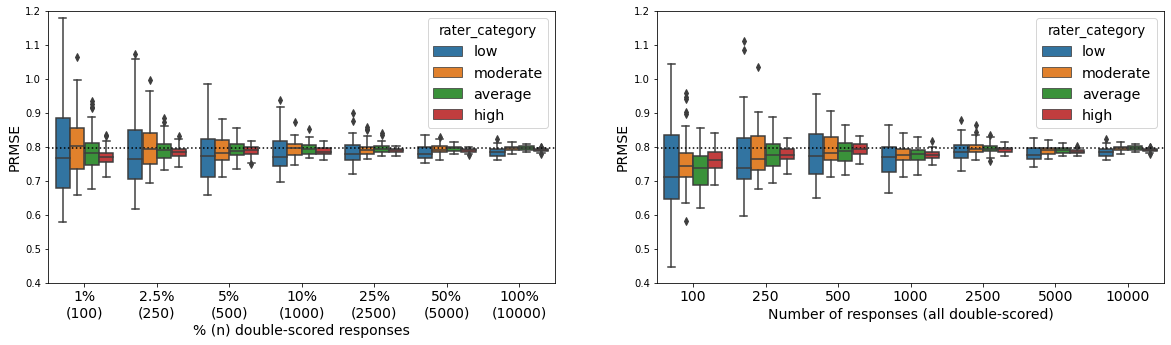

In [31]:
# create a figure with 2 subplots
fig, axes = plt.subplots(1, 2);
fig.set_size_inches(20, 5)

with sns.plotting_context('notebook', font_scale=1.3):

    for prmse_type, ax in zip(['percent', 'number'], axes):


        # choose what goes on the x and y axes
        x_column = 'percent_double_scored' if prmse_type == 'percent' else 'num_double_scored'
        y_column = 'prmse_percent' if prmse_type == 'percent' else 'prmse_number'

        # set the x-axis labels and tick labels appropriately
        x_label = "% (n) double-scored responses" if prmse_type == 'percent' else 'Number of responses (all double-scored)'

        percent_ticklabels = [f"{pct}%\n({num})" for pct, num in zip(double_scored_percentages,
                                                                      df_metrics_double_scored_with_categories['num_double_scored'])]
        number_ticklabels = df_metrics_double_scored_with_categories['num_double_scored'].tolist()
        x_ticklabels = percent_ticklabels if prmse_type == 'percent' else number_ticklabels

        # now add the the boxplot of the PRMSE values
        sns.boxplot(x=x_column,
                    y=y_column,
                    hue='rater_category',
                    hue_order=dataset.rater_categories,
                    data=df_metrics_double_scored_with_categories,
                    ax=ax)

        # and set the axis labels
        ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel("PRMSE", fontsize=14)
        ax.set_xticklabels(x_ticklabels)
        ax.tick_params('x', labelsize=14)

        # There are several outlier values of PRMSE at 1.6. We remove them to reduce the white space on the plots
        # and make a note in the caption.
        # We'll add them back before release. 
        ax.set_ylim(0.4, 1.2)

        # we also want to add in a line showing the R2 score between the simulated true scores
        # and the scores from our chosen simulated system
        r2_true_system_score = r2_score(df_scores['true'], df_scores[chosen_system])
        ax.axhline(r2_true_system_score, color='black', ls=':')
   
    plt.savefig(figure_dir / 'percentage.png', bbox_inches="tight")
    plt.show()

These plots shows that PRMSE scores are much more stable with a larger percentage of double-scored responses and what matters is the number of double scored responses, not the percentage. A good rule of thumb is to have at least 1000 double-scored responses. 

We can also look at the same data in tabular format. For simplicity, we will use the range of values as the measure of spread.

In [10]:
# group the metrics by the double-scoring percentage and then by rater category
grouper = df_metrics_double_scored_with_categories.groupby(['percent_double_scored', 
                                                            'rater_category'])
# compute the descriptives over the groups, for the PRMSE metric
df_prmse_descriptives = grouper['prmse_percent'].describe()

# compute the range as the difference between the maximum PRMSE value and the minimum
df_prmse_descriptives['range'] = df_prmse_descriptives['max'] - df_prmse_descriptives['min']

# get the range as a separate dataframe and print out in rater category order
df_prmse_range = df_prmse_descriptives['range'].unstack()[dataset.rater_categories]
df_prmse_range

rater_category,low,moderate,average,high
percent_double_scored,,,,
1.0,1.010176,0.405627,0.260800,0.122973
2.5,0.455254,0.302736,0.150803,0.088995
5.0,0.326148,0.170422,0.122148,0.069175
10.0,0.240592,0.127596,0.084640,0.055022
25.0,0.180157,0.092271,0.067730,0.030554
50.0,0.083217,0.066545,0.037641,0.024934
100.0,0.059957,0.034016,0.022005,0.020628


In [11]:
# TODO: remove latex table for final release
print(df_prmse_range.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
rater\_category &  low &  moderate &  average &  high \\
percent\_double\_scored &      &           &          &       \\
\midrule
1.0                   & 1.01 &      0.41 &     0.26 &  0.12 \\
2.5                   & 0.46 &      0.30 &     0.15 &  0.09 \\
5.0                   & 0.33 &      0.17 &     0.12 &  0.07 \\
10.0                  & 0.24 &      0.13 &     0.08 &  0.06 \\
25.0                  & 0.18 &      0.09 &     0.07 &  0.03 \\
50.0                  & 0.08 &      0.07 &     0.04 &  0.02 \\
100.0                 & 0.06 &      0.03 &     0.02 &  0.02 \\
\bottomrule
\end{tabular}



Next, we look at the other conventional agrement metrics to see how they vary with the number of double-scored responses available.

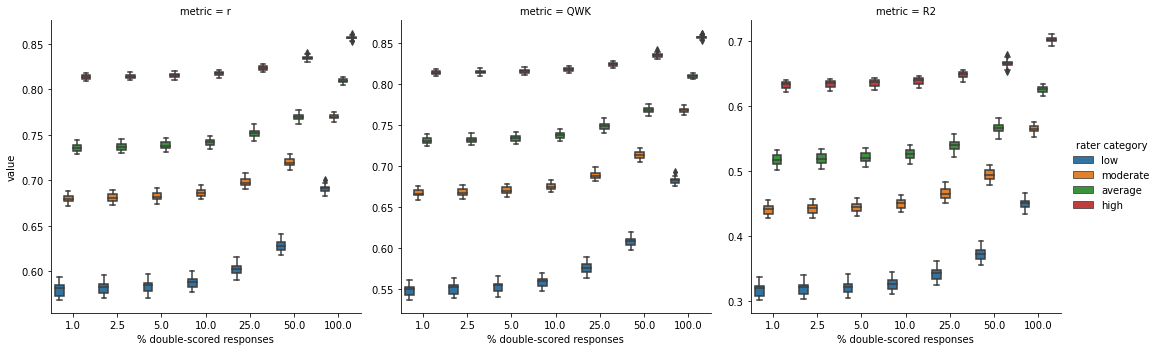

In [12]:
# extract out only the agreement metrics columns along with the percentage and the rater category
df_agreement_double_scored = df_metrics_double_scored_with_categories[['rater_category', 'r', 'QWK', 'R2', 'percent_double_scored']]

# now create a longer version of this data frame that's more amenable to plotting
df_agreement_double_scored_long = df_agreement_double_scored.melt(id_vars=['percent_double_scored', 'rater_category'],
                                                                  var_name='metric')
# make the plot
g = sns.catplot(x='percent_double_scored',
                y='value',
                col='metric',
                hue='rater_category',
                hue_order=dataset.rater_categories,
                kind='box',
                sharey=False,
                data=df_agreement_double_scored_long)
g.set_axis_labels("% double-scored responses", "value")
g._legend.set_title('rater category')
plt.savefig(figure_dir / 'percentage_other.png');
plt.show()

These plots show that the agreement metrics are not as stable as PRMSE even with more double-scored responses and still depend significantly on how well the two raters agreed with each other.